In [1]:
import ast, glob
import pandas as pd
import numpy as np
import requests, io
import matplotlib as mpl
from astropy.time import Time
from datetime import datetime
import matplotlib.pyplot as plt
from myutils import data_utils as du

In [2]:
fink_colors_list = ["#15284F", "#F5622E", "#D5D5D3", "#3C8DFF"]
fink_colors_dic = {"FINK":"#15284F", "ZTF":"#F5622E", "TNS":"#D5D5D3"}

In [3]:
mpl.rcParams["font.size"] = 16
mpl.rcParams["legend.fontsize"] = "medium"
mpl.rcParams["figure.titlesize"] = "large"
mpl.rcParams["lines.linewidth"] = 3

# Data

### TNS classifications within time-range of experiment

In [4]:
# read TNS labels and apply timeranges for this experiment
df_dic = {}
df_TNS_tmp = du.load_TNS_reformat('../classifications/tns_fink_20230817.parquet')
df_dic['TNS'] = du.apply_timerange_fink_fup(df_TNS_tmp, ndaysplus=9)
# two types are missing, they are non Ia so AL loop is ok
df_dic['TNS'].loc[df_dic['TNS']['ztf_names'] == "ZTF24aahsmkt", 'type'] = "II"
df_dic['TNS'].loc[df_dic['TNS']['ztf_names'] == "ZTF23abfpegt", 'type'] = "IIB"
df_dic['TNS'].loc[df_dic['TNS']['ztf_names'] == "ZTF24aakaiha", 'type'] = "TDE" # reclassified from Ia to TDE-He 7/6/24
df_dic['TNS'].loc[df_dic['TNS']['type']=='DE', 'type'] = "TDE"

# classified by ZTF
df_dic['ZTF'] = df_dic['TNS'][df_dic['TNS']['reporting_group']=='ZTF']

# FINK
tmp0 = pd.read_csv('../classifications/ALbot_with_classifications_curated_original.tsv', sep='\t')
tmp0 = pd.merge(tmp0, df_dic['TNS'][['ztf_names', 'type']], on='ztf_names', how='left')
# nonIa types missing, adding these tags
tmp = pd.read_csv('../classifications/ALbot_with_classifications_curated_original_nonIatypes.csv', sep=' ')
tmp = tmp.rename(columns={'type':'classtmp'}) 
df_merged = pd.merge(tmp0, tmp, on='ztf_names', how='left')
df_merged['type'] = df_merged.apply(lambda row: row.classtmp if row.type is np.nan else row.type, axis=1)
df_merged['type'] = df_merged.apply(lambda row: row.Classification if row.type is np.nan else row.type, axis=1)
df_dic['FINK'] = df_merged


BEWARE! Not all detected by ZTF will enter in our AL loop (with valid features), so we need to subsample

In [5]:
# load metrics
metrics_dic = {}
metrics_dic["FINK"] = pd.read_csv('../dump/data_fink/metrics.csv')
metrics_dic["ZTF"] = pd.read_csv('../dump/data_ZTF/metrics.csv')
metrics_dic["TNS"] = pd.read_csv('../dump/data_allTNS/metrics.csv')


In [6]:
used_names_dic = {}
for k in metrics_dic.keys():
    tmp= metrics_dic[k]['query_objectIds'].apply(ast.literal_eval)
    # Flatten the column to a list
    used_names_dic[k] = tmp.explode().tolist()


In [7]:
# filter to those used in AL loop
for k in df_dic.keys():
    print(f"{k} before filtering: {df_dic[k].shape[0]}")
    df_dic[k] = df_dic[k][df_dic[k]['ztf_names'].isin(used_names_dic[k])]
    print(f"{k} after filtering: {df_dic[k].shape[0]}")


TNS before filtering: 622
TNS after filtering: 302
ZTF before filtering: 256
ZTF after filtering: 135
FINK before filtering: 96
FINK after filtering: 92


In [91]:
# In the AL loop, we followed- up more than these
# print(df_dic['FINK'].groupby('type').size().to_latex(index=True))

### Types in AL loop

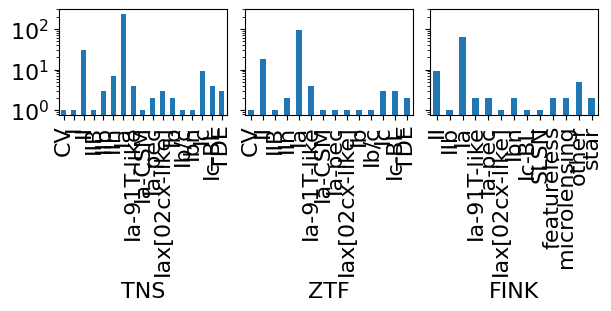

In [9]:
fig = plt.figure(constrained_layout=True, figsize=(6, 3))
gs = fig.add_gridspec(1, 3)
axs = gs.subplots(sharex=False, sharey=True)
df_dic['TNS'].groupby('type').size().plot(kind='bar', ax= axs[0],xlabel='TNS')
df_dic['ZTF'].groupby('type').size().plot(kind='bar', ax= axs[1],xlabel='ZTF')
df_dic['FINK'].groupby('type').size().plot(kind='bar', ax= axs[2],xlabel='FINK')
plt.yscale('log')


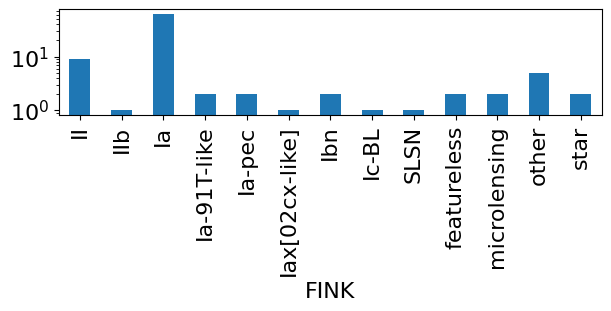

In [10]:
fig = plt.figure(constrained_layout=True, figsize=(6, 3))
df_dic['FINK'].groupby('type').size().plot(kind='bar',xlabel='FINK')
plt.yscale('log')


Family of types may be more indicative

In [11]:
all_types = np.concat([df_dic[k]['type'].unique() for k in df_dic.keys()])
set(all_types)

{'CV',
 'I',
 'II',
 'IIB',
 'IIb',
 'IIn',
 'Ia',
 'Ia-91T-like',
 'Ia-CSM',
 'Ia-pec',
 'Iax[02cx-like]',
 'Ib',
 'Ib/c',
 'Ibn',
 'Ic',
 'Ic-BL',
 'SLSN',
 'TDE',
 'featureless',
 'microlensing',
 'other',
 'star'}

In [12]:
family_types = {
    'star':['CV','star'],
    'SNIbc':['I','Ib', 'Ib/c', 'Ibn', 'Ic', 'Ic-BL'],
    'SNIa-like':['Ia', 'Ia-91T-like', 'Ia-CSM', 'Ia-pec', 'Iax[02cx-like]'],
    'SNII':['II', 'IIB', 'IIb', 'IIn'],
    'SLSN':['SLSN'],
    'TDE':['TDE'],
    'other':['featureless', 'microlensing', 'other']}

def get_family(x, family_types):
    for k in family_types.keys():
        if x in family_types[k]:
            return k
    return 'unknown'

for k in df_dic.keys():
    df_dic[k]['type families'] = df_dic[k]['type'].apply(lambda x: get_family(x, family_types))

/var/folders/hj/2gy38d5s5mj7n7cln0xf7kjh249zrd/T/ipykernel_38695/1869745522.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dic[k]['type families'] = df_dic[k]['type'].apply(lambda x: get_family(x, family_types))


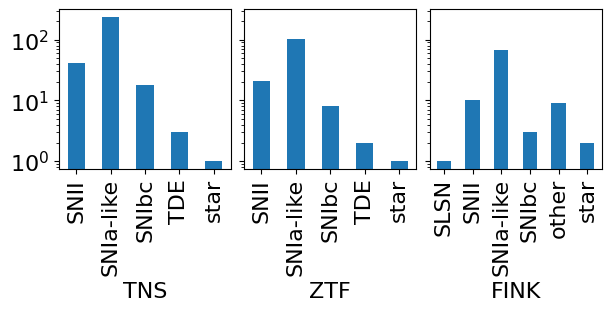

In [13]:
fig = plt.figure(constrained_layout=True, figsize=(6, 3))
gs = fig.add_gridspec(1, 3)
axs = gs.subplots(sharex=False, sharey=True)
df_dic['TNS'].groupby('type families').size().plot(kind='bar', ax= axs[0],xlabel='TNS')
df_dic['ZTF'].groupby('type families').size().plot(kind='bar', ax= axs[1],xlabel='ZTF')
df_dic['FINK'].groupby('type families').size().plot(kind='bar', ax= axs[2],xlabel='FINK')
plt.yscale('log')


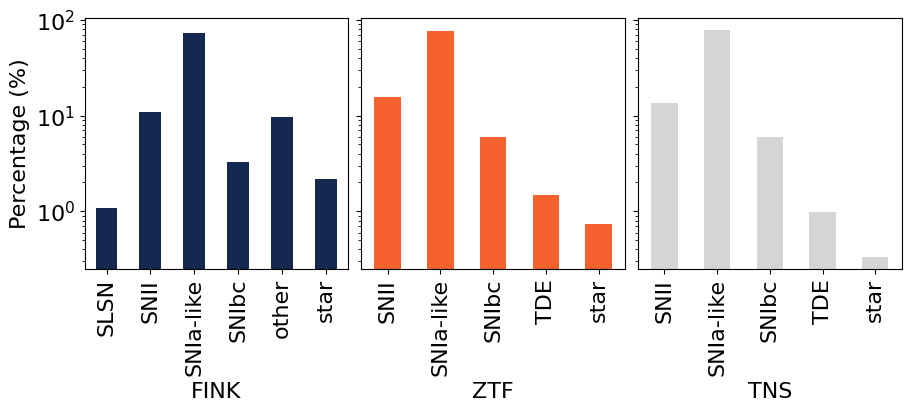

In [14]:
# Create figure and subplots with gridspec
fig = plt.figure(constrained_layout=True, figsize=(9, 4))
gs = fig.add_gridspec(1, 3)
axs = gs.subplots(sharex=False, sharey=True)

# Function to calculate percentages and plot
def plot_percentage(df, ax, label):
    # Calculate percentages
    counts = df.groupby('type families').size()
    percentages = (counts / counts.sum()) * 100
    # Plot bar chart
    percentages.plot(kind='bar', ax=ax, xlabel=label,color=fink_colors_dic[label])
    ax.set_ylabel('Percentage (%)')

# Plot each DataFrame with percentages on a separate subplot
plot_percentage(df_dic['TNS'], axs[2], 'TNS')
plot_percentage(df_dic['ZTF'], axs[1], 'ZTF')
plot_percentage(df_dic['FINK'], axs[0], 'FINK')

# Apply log scale to the y-axis for each subplot (if needed for percentage)
for ax in axs:
    ax.set_yscale('log')

plt.savefig('../plots/ALloop_types.png', bbox_inches='tight')
# Display the plot
plt.show()




In [15]:
df_dic['TNS'][df_dic['TNS']['type families']=='unknown']

,ztf_names,type AL,discoveryjd,type,reporting_group,fup requested,fup requested (str),label acquired,type families


### Follow-up magnitude in AL loop
instead of querying Fink as in AL loop, we can use the queried data files

In [16]:
df_mags_dic={}
path_dic = {'FINK':'../dump/data_fink/', 'ZTF':'../dump/data_ZTF/', 'TNS':'../dump/data_allTNS/'}
for k in df_dic.keys():
    list_tmp = []
    for l, fil in enumerate(np.sort(glob.glob(f'{path_dic[k]}/*/*/queries/alert_data.csv'))):
        tmp = pd.read_csv(fil)
        tmp['mag_list'] =tmp['cmagpsf'].apply(lambda x: list(map(float, x.strip('[]').split())))
        tmp['mag_last_value'] = tmp['mag_list'].apply(lambda x: x[-1])
        tmp['photometric measurements'] = tmp['mag_list'].apply(len)
        tmp['loop']= np.ones(len(tmp))*l
        list_tmp.append(tmp[['objectId','mag_last_value','photometric measurements','loop']])
    df_mags_dic[k] = pd.concat(list_tmp)

TNS 19.470484499999998 \pm 0.7189964653409605
ZTF 19.463097 \pm 0.6479567984863929
FINK 19.5310075 \pm 0.6799351257597739


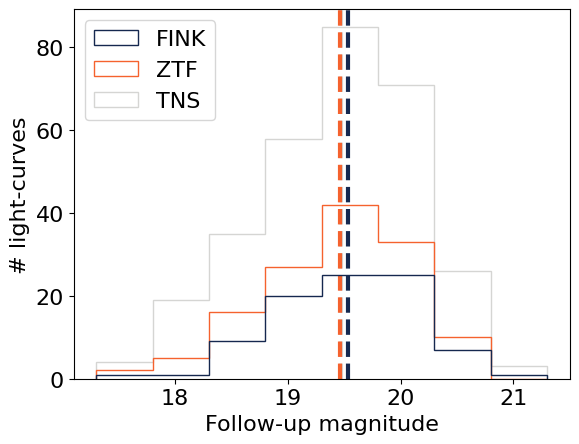

In [17]:
mybins = np.arange(17.3,21.5,.5)
for k in df_mags_dic.keys():
    plt.hist(df_mags_dic[k]['mag_last_value'],label=k, bins=mybins,histtype='step',color=fink_colors_dic[k])
    plt.axvline(df_mags_dic[k]['mag_last_value'].median(), color=fink_colors_dic[k], linestyle='--')
    print(f"{k} {df_mags_dic[k]['mag_last_value'].median()} \pm {df_mags_dic[k]['mag_last_value'].std()}")
plt.legend()
plt.xlabel('Follow-up magnitude')
plt.ylabel('# light-curves')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])  # Invert order


#### Does this evolve with loop?



19.724445 \pm 0.8079853362659717
19.537792 \pm 0.5598532914795652
19.4426935 \pm 0.589247035956103


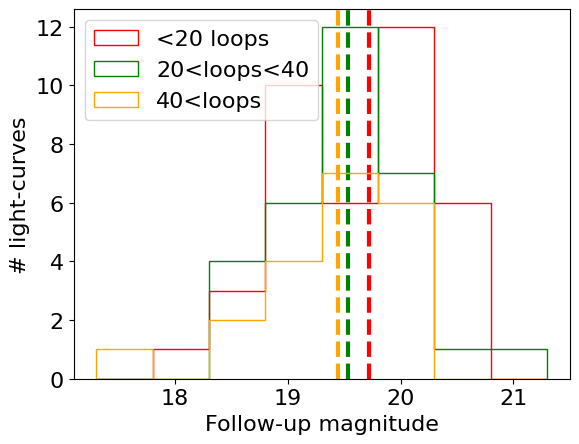

In [18]:
mybins = np.arange(17.3,21.5,0.5)

sel1 = df_mags_dic['FINK'][df_mags_dic['FINK']['loop'] <20]
sel2 = df_mags_dic['FINK'][(df_mags_dic['FINK']['loop'] >=20) & (df_mags_dic['FINK']['loop'] <40)]
sel3= df_mags_dic['FINK'][(df_mags_dic['FINK']['loop'] >=40)]

plt.hist(sel1['mag_last_value'],label='<20 loops', bins=mybins,histtype='step',color='red')
plt.axvline(sel1['mag_last_value'].median(), color='red', linestyle='--')
print(f"{sel1['mag_last_value'].median()} \pm {sel1['mag_last_value'].std()}")


plt.hist(sel2['mag_last_value'],label='20<loops<40', bins=mybins,histtype='step',color='green')
plt.axvline(sel2['mag_last_value'].median(), color='green', linestyle='--')
print(f"{sel2['mag_last_value'].median()} \pm {sel2['mag_last_value'].std()}")

plt.hist(sel3['mag_last_value'],label='40<loops', bins=mybins,histtype='step',color='orange')
plt.axvline(sel3['mag_last_value'].median(), color='orange', linestyle='--')
print(f"{sel3['mag_last_value'].median()} \pm {sel3['mag_last_value'].std()}")

plt.xlabel('Follow-up magnitude')
plt.ylabel('# light-curves')
plt.legend()



# Followup by type and magnitude?

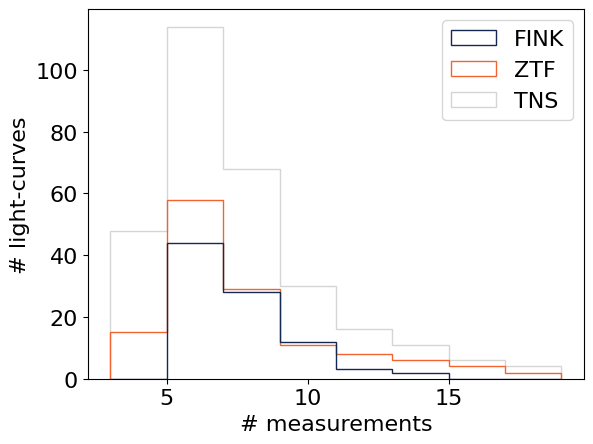

In [19]:
mybins = np.arange(3,20,2)
for k in df_mags_dic.keys():
    plt.hist(df_mags_dic[k]['photometric measurements'],label=k, bins=mybins,histtype='step',color=fink_colors_dic[k])
plt.legend()
plt.xlabel('# measurements')
plt.ylabel('# light-curves')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])  # Invert order

# List of fup targets for DLR xmatch

In [20]:
all_fup_names = []
for k in used_names_dic.keys():
    all_fup_names += used_names_dic[k]

In [21]:
# import requests, io
# list_df = []
# for objid in all_fup_names:
#     r = requests.post(
#         "https://fink-portal.org/api/v1/objects",
#         json={
#             "objectId": objid,
#             "output-format": "json",
#             "columns": "i:objectId,i:ra,i:dec",
#         },
#     )
#     pdf_tmp = pd.read_json(io.BytesIO(r.content))
#     list_df.append(pdf_tmp.iloc[:1])
# pdf_dlr = pd.concat(list_df)

In [22]:
# pdf_dlr.to_csv('../dump/to_crossmatch_host.csv',index=False)

# Targets without tags (follow-up scheduled but no classification)

In [99]:
df_all_fup = pd.read_csv('../classifications/ALbot_allfup.csv')
df_all_fup.sort_values('Appears in bot',ascending=True)
df_all_fup = df_all_fup.drop_duplicates(subset=['ztf_name'],keep='first')
print(f"All bot light-curves {len(df_all_fup)}")


All bot light-curves 177


In [103]:
print(f"With classification {len(df_all_fup[~df_all_fup['Classification'].isna()])}")
df_all_fup['Sent for followup'].unique()

With classification 109


array(['Yes', 'TNS', 'No'], dtype=object)

In [105]:
print(f"Not sent for follow-up {len(df_all_fup[(df_all_fup['Sent for followup']=='No')])}")
print(f"Not sent for follow-up because classification in TNS {len(df_all_fup[(df_all_fup['Sent for followup']=='No') & (~df_all_fup['Classification'].isna())])}")
df_no_classification = df_all_fup[df_all_fup['Classification'].isna()].copy()
print(f"Sent for fup and no classification obtained {len(df_no_classification)}")

df_no_classification['fup requested'] = [Time(datetime.strptime(d[0], '%d/%m/%Y')).jd for d in df_no_classification[['Appears in bot']].values]
df_no_classification["fup requested (str)"] = df_no_classification.loc[:, "fup requested"].apply(
        lambda x: Time(x, format="jd").strftime("%Y%m%d")
    )
df_no_classification['label acquired'] = df_no_classification['fup requested'] + 1
df_no_classification = df_no_classification.rename(columns={'ztf_name':'i:objectId'})

Not sent for follow-up 37
Not sent for follow-up because classification in TNS 13
Sent for fup and no classification obtained 68


In [96]:
# for AL loop
df_for_ALloop = pd.read_csv('../classifications/ALbot_with_classifications_curated_original.tsv', sep='\t')
print(f"Given to the loop light-curves {len(df_for_ALloop)}")
print(f"In metrics {len(df_dic['FINK'])}")
print([k for k in df_for_ALloop.ztf_names.values if k not in df_dic['FINK'].ztf_names.values])

# print(df_all_fup[df_all_fup['ztf_name'].isin(df_for_ALloop.ztf_names.values)].groupby('Classification').size().to_latex(index=True))

# print(df_all_fup[df_all_fup['ztf_name'].isin(df_dic['FINK'].ztf_names.values)].groupby('Classification').size().to_latex(index=True))


Given to the loop light-curves 94
In metrics 92
['ZTF23abceaws', 'ZTF24aaomuhe', 'ZTF24aasfxgh', 'ZTF24aawxqj']


In [79]:
print(len([k for k in df_dic['FINK'].ztf_names.values if k in df_all_fup.ztf_name.values]))
name_notin_fup = [k for k in df_dic['FINK'].ztf_names.values if k not in df_all_fup.ztf_name.values]
df_dic['FINK'][df_dic['FINK'].ztf_names==name_notin_fup[0]]

91


,Appears in bot,ztf_names,Classification,Time sent for follow-up,type,classtmp,type families
57,07/05/2024,ZTF24aalpgky,other,2460438.5,other,NaN,other


In [73]:
names_not_in_AL_loop = [k for k in df_all_fup.ztf_name.values if k not in  df_dic['FINK'].ztf_names.values]
df_all_fup[df_all_fup.ztf_name.isin(names_not_in_AL_loop)]

,ztf_name,Appears in bot,Sent for followup,Classification
0,ZTF23abceaws,26/09/2023,Yes,Nova
1,ZTF23abcledv,21/09/2023,Yes,NaN
3,ZTF23abedduu,22/09/2023,Yes,NaN
4,ZTF23abevyuq,27/09/2023,Yes,NaN
5,ZTF23abfxhnx,22/09/2023,Yes,NaN
...,...,...,...,...
178,ZTF24abfzzhc,20/9/2024,Yes,NaN
179,ZTF24abhcptk,20/9/2024,No,AGN
180,ZTF24abgviom,20/9/2024,No,NaN
181,ZTF24abhbvwm,20/9/2024,Yes,Ia


Not sent for follow-up 37
Not sent for follow-up because classification in TNS 13
Sent for fup and no classification obtained 68


In [52]:
len(df_all_fup[~df_all_fup['Classification'].isna()])

109

In [53]:
len(df_no_classification)

68

In [54]:
list_df = []
for objid in df_no_classification['i:objectId'].unique():
    r = requests.post(
        "https://fink-portal.org/api/v1/objects",
        json={
            "objectId": objid,
            "output-format": "json",
            "columns": "i:objectId,i:magpsf,i:sigmapsf,i:fid,i:jd",
        },
    )
    pdf_tmp = pd.read_json(io.BytesIO(r.content))
    list_df.append(pdf_tmp)
pdf_lc_noclass = pd.concat(list_df)

In [55]:
len(pdf_lc_noclass)

999

In [56]:
pdf_lc_noclass.keys()

Index(['i:fid', 'i:sigmapsf', 'i:jd', 'i:magpsf', 'i:objectId'], dtype='object')

In [57]:
# need to limit the time for follow-up
merged = pd.merge(pdf_lc_noclass,df_no_classification[['i:objectId','fup requested']], on='i:objectId', how='left')
filtered_pdf_lc_noclass = merged[merged['i:jd'] < merged['fup requested']]

In [58]:
latest_ijd_noclass = filtered_pdf_lc_noclass.loc[filtered_pdf_lc_noclass.groupby('i:objectId')['i:jd'].idxmax()]

# Selecting only the original columns from df2
latest_ijd_noclass = latest_ijd_noclass[['i:fid', 'i:jd', 'i:magpsf','i:sigmapsf', 'i:objectId']]

Fink 19.5310075 \pm 0.6799351257597739
no Class 19.453611 \pm 0.4970044659925941
No fup 19.531390000000002 \pm 0.47695130162292504


/var/folders/hj/2gy38d5s5mj7n7cln0xf7kjh249zrd/T/ipykernel_38695/1280532469.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


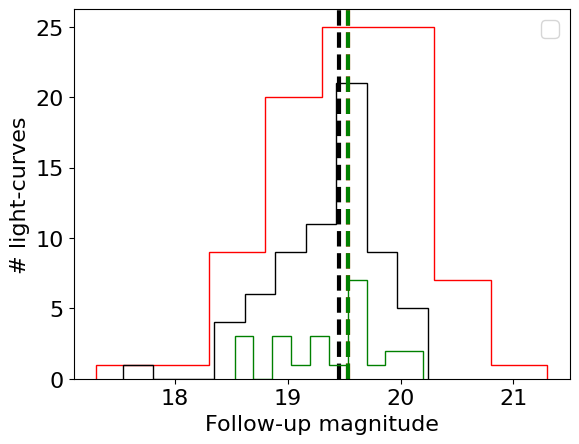

In [59]:
mybins = np.arange(17.3,21.5,0.5)


plt.hist(df_mags_dic['FINK']['mag_last_value'], bins=mybins,histtype='step',color='red')
plt.axvline(df_mags_dic['FINK']['mag_last_value'].median(), color='red', linestyle='--')
print(f"Fink {df_mags_dic['FINK']['mag_last_value'].median()} \pm {df_mags_dic['FINK']['mag_last_value'].std()}")

plt.hist(latest_ijd_noclass['i:magpsf'], histtype='step',color='black')
plt.axvline(latest_ijd_noclass['i:magpsf'].median(), color='black', linestyle='--')
print(f"no Class {latest_ijd_noclass['i:magpsf'].median()} \pm {latest_ijd_noclass['i:magpsf'].std()}")

sel = latest_ijd_noclass[latest_ijd_noclass['i:objectId'].isin(df_not_sent_fup['ztf_name'].values)]
plt.hist(sel['i:magpsf'], histtype='step',color='green')
plt.axvline(sel['i:magpsf'].median(), color='green', linestyle='--')
print(f"No fup {sel['i:magpsf'].median()} \pm {sel['i:magpsf'].std()}")


plt.xlabel('Follow-up magnitude')
plt.ylabel('# light-curves')
plt.legend()





NameError: name 'colordic' is not defined

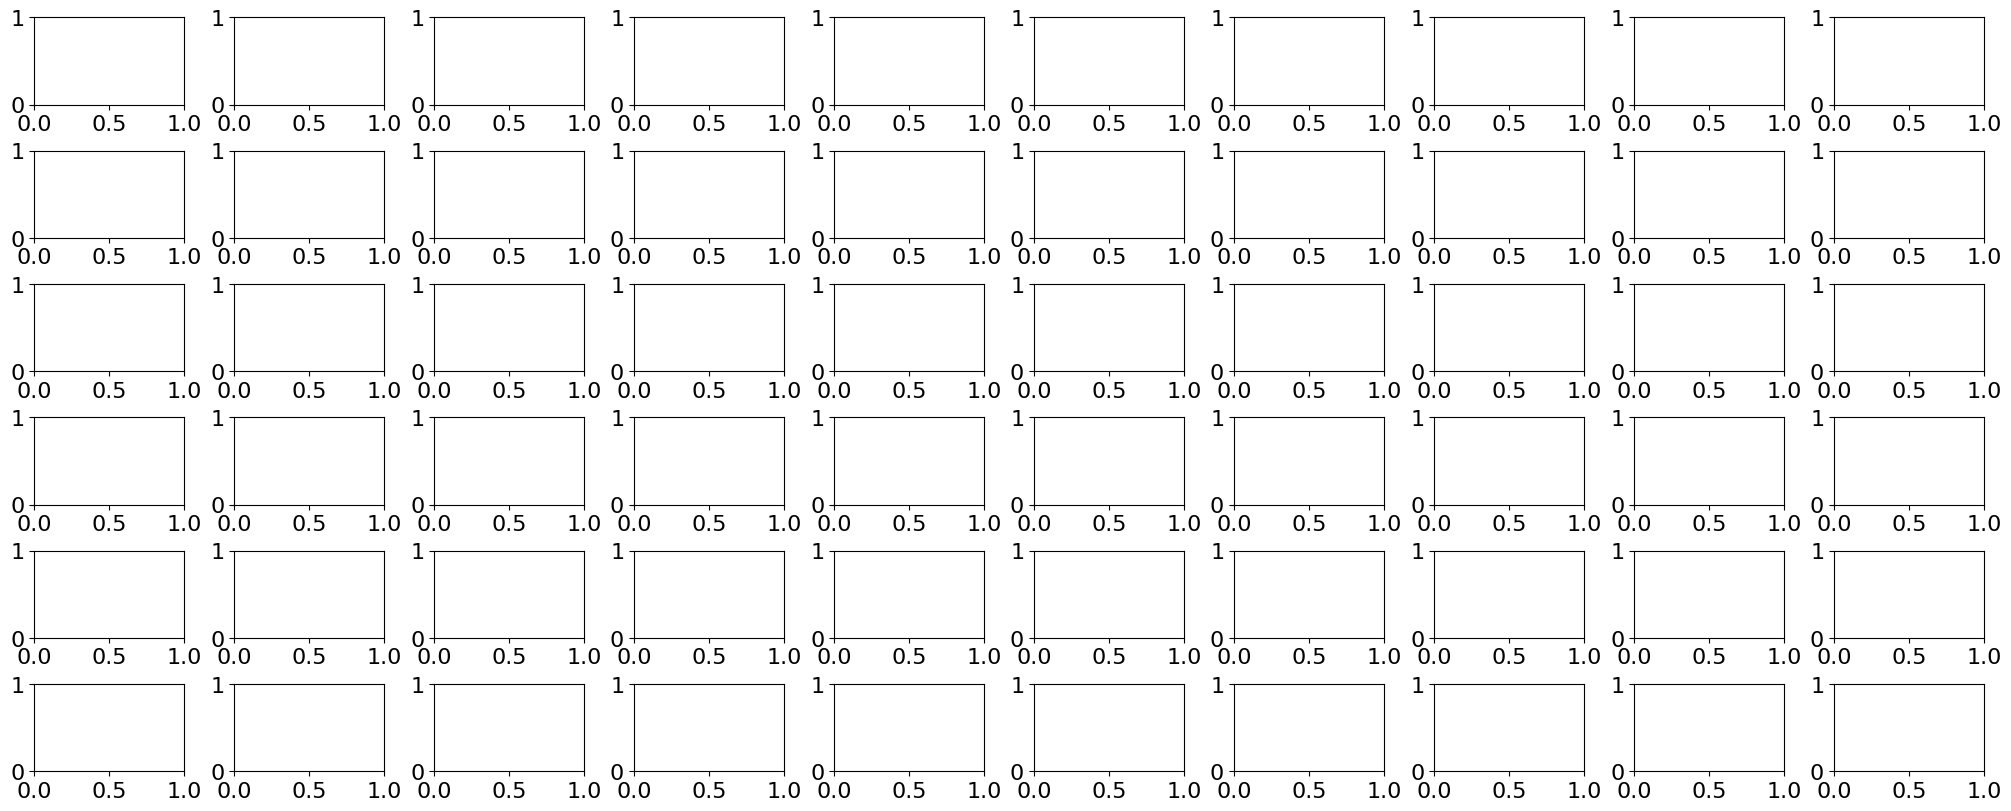

In [60]:
# Function to plot a single page (60 plots) of `latest_df2`
def plot_page(page_df, page_num):
    fig = plt.figure(constrained_layout=True, figsize=(20, 8))
    gs = fig.add_gridspec(6, 10)
    axs = gs.subplots(sharex=False, sharey=False)

    # Plot each unique objectId in the page_df
    for idx, (obj_id, group) in enumerate(page_df.groupby('i:objectId')):
        row, col_num = divmod(idx, 10)  # Calculate row and column for the subplot
        min_jd = group['i:jd'].min()
        for flt in group['i:fid'].unique():
            group_flt = group[group['i:fid'] == flt]
            relative_jd = group_flt['i:jd'] - min_jd
            axs[row, col_num].errorbar(relative_jd, group_flt['i:magpsf'],yerr=group_flt['i:sigmapsf'], color=colordic[flt])
        axs[row, col_num].set_title(obj_id, fontsize=8)
        axs[row, col_num].invert_yaxis()  # Optional: invert to show magnitude decreasing upward
        axs[row, col_num].tick_params(labelsize=6)
        # axs[row, col_num].set_xlabel('Days since min JD')  # Optional: label x-axis

    plt.suptitle(f"Page {page_num + 1}")
    plt.show()

# Split `filtered_pdf_lc_noclass` into chunks of 60 and plot each chunk
chunk_size = 60
for page_num, start in enumerate(range(0, len(filtered_pdf_lc_noclass['i:objectId'].unique()), chunk_size)):
    end = start + chunk_size
    page_df = filtered_pdf_lc_noclass[filtered_pdf_lc_noclass['i:objectId'].isin(filtered_pdf_lc_noclass['i:objectId'].unique()[start:end])]
    plot_page(page_df, page_num)

#### it looks like they peaked around 19, is this true?

19.166248500000002 0.5910992900295649


Text(0, 0.5, '#')

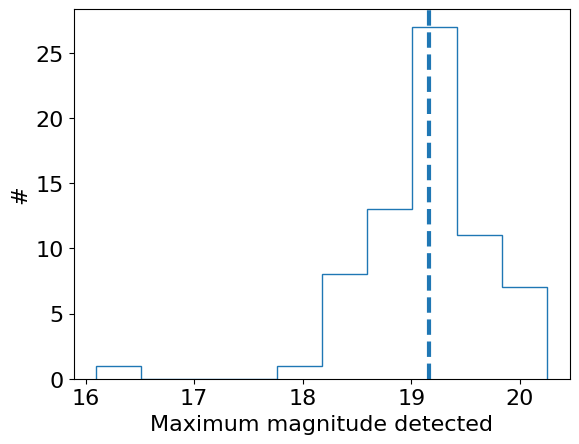

In [50]:
# use before jd filtering 
plt.hist(pdf_lc_noclass.groupby('i:objectId').min()['i:magpsf'],histtype='step')
plt.axvline(pdf_lc_noclass.groupby('i:objectId').min()['i:magpsf'].median(), linestyle='--')
print(pdf_lc_noclass.groupby('i:objectId').min()['i:magpsf'].median(), pdf_lc_noclass.groupby('i:objectId').min()['i:magpsf'].std())
plt.xlabel('Maximum magnitude detected')
plt.ylabel('#')

In [71]:
# # lets check the other lcs
# dic_minmag ={}
# for k in ['ZTF','TNS', 'FINK']:
#     list_df = []
#     for objid in df_mags_dic[k]['objectId'].unique():
#         r = requests.post(
#             "https://fink-portal.org/api/v1/objects",
#             json={
#                 "objectId": objid,
#                 "output-format": "json",
#                 "columns": "i:objectId,i:magpsf",
#             },
#         )
#         pdf_tmp = pd.read_json(io.BytesIO(r.content))
#         pdf_tmp = pdf_tmp.groupby('i:objectId').min()['i:magpsf']
#         list_df.append(pdf_tmp)
#     dic_minmag[k] = pd.concat(list_df)


TNS 18.316710999999998
ZTF 18.3252
FINK 18.320594999999997
FINK lost 19.166248500000002 0.5910992900295649


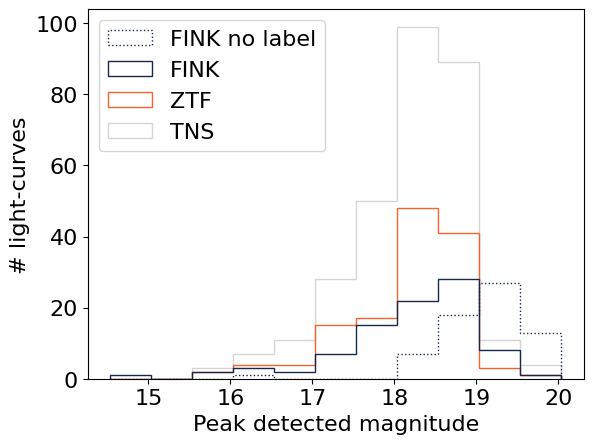

In [96]:
# plot histo
minmagglobal = np.min([dic_minmag[k].min() for k in dic_minmag.keys()])
maxmagglobal = np.min([dic_minmag[k].max() for k in dic_minmag.keys()])
mybins = np.arange(minmagglobal,maxmagglobal+.5,0.5)
for k in ['TNS','ZTF','FINK']:
    plt.hist(dic_minmag[k].values,histtype='step',color=fink_colors_dic[k],label=k, bins= mybins)
    # plt.axvline(dic_minmag[k].median(), linestyle='--',color=fink_colors_dic[k])
    print(k, dic_minmag[k].median())
    
plt.hist(pdf_lc_noclass.groupby('i:objectId').min()['i:magpsf'],histtype='step',color=fink_colors_dic["FINK"], label='FINK no label',linestyle='dotted', bins= mybins)
# plt.axvline(pdf_lc_noclass.groupby('i:objectId').min()['i:magpsf'].median(),color=fink_colors_dic["FINK"],linestyle='dotted')
print('FINK lost', pdf_lc_noclass.groupby('i:objectId').min()['i:magpsf'].median(), pdf_lc_noclass.groupby('i:objectId').min()['i:magpsf'].std())
plt.xlabel('Peak detected magnitude')
plt.ylabel('# light-curves')
plt.legend()
# plt.yscale('log')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])  # Invert order
plt.savefig('../plots/ALloop_peakmag.png', bbox_inches='tight')

FINK lost 19.166248500000002 0.5910992900295649


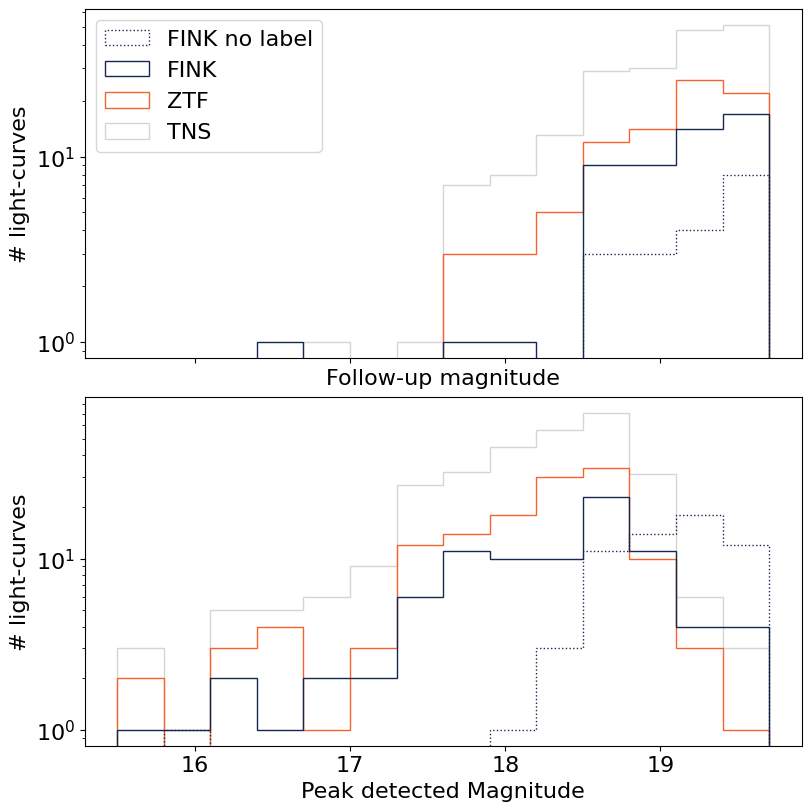

In [120]:
# Follow-up magnitude and peak magnitude
maxmagglobal = np.min([dic_minmag[k].max() for k in dic_minmag.keys()])
mybins = np.arange(15.5,maxmagglobal+.3,0.3) # eliminating one bright object

fig = plt.figure(constrained_layout=True, figsize=(8, 8))
gs = fig.add_gridspec(2, 1)
axs = gs.subplots(sharex=True, sharey=False)

for k in df_mags_dic.keys():
    axs[0].hist(df_mags_dic[k]['mag_last_value'],label=k, bins=mybins,histtype='step',color=fink_colors_dic[k])
    # axs[0].axvline(df_mags_dic[k]['mag_last_value'].median(), color=fink_colors_dic[k], linestyle='--')
sel = latest_ijd_noclass[latest_ijd_noclass['i:objectId'].isin(df_not_sent_fup['ztf_name'].values)]
axs[0].hist(sel['i:magpsf'], histtype='step',color=fink_colors_dic["FINK"], label='FINK no label',linestyle='dotted',bins=mybins,linewidth=2)
axs[0].tick_params(axis='both', which='both', bottom=True,  left=True) 
axs[0].set_xlabel('Follow-up magnitude')
axs[0].set_ylabel('# light-curves')
axs[0].set_yscale('log')


for k in ['TNS','ZTF','FINK']:
    axs[1].hist(dic_minmag[k].values,histtype='step',color=fink_colors_dic[k],label=k, bins= mybins,linewidth=2)
    
axs[1].hist(pdf_lc_noclass.groupby('i:objectId').min()['i:magpsf'],histtype='step',color=fink_colors_dic["FINK"], label='FINK no label',linestyle='dotted', bins= mybins,linewidth=2))
print('FINK lost', pdf_lc_noclass.groupby('i:objectId').min()['i:magpsf'].median(), pdf_lc_noclass.groupby('i:objectId').min()['i:magpsf'].std())
axs[1].set_xlabel('Peak detected Magnitude')
axs[1].set_ylabel('# light-curves')
handles, labels = plt.gca().get_legend_handles_labels()
axs[0].legend(handles[::-1], labels[::-1])  # Invert order
axs[1].set_yscale('log')
plt.savefig('../plots/ALloop_peak_fup_mag.png', bbox_inches='tight')